In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
from data_analysis_helper_fun import normalized_heat_maps_by_weights

## Loading Data

In [3]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_20231108_process_results'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, data_file_name)

# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [4]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 2047
   Number of dialectical structures: 8
   Overall number of initial commitments: 20
   Sentence-pools: [6 7]
   Models: ['StandardGlobalReflectiveEquilibrium'
 'StandardGlobalReflectiveEquilibriumLinearG'
 'StandardLocalReflectiveEquilibrium'
 'StandardLocalReflectiveEquilibriumLinearG']




In [5]:
re_data.columns

Index(['model_name', 'ds', 'tau_name', 'n_sentence_pool', 'ds_arg_size',
       'ds_infer_dens', 'ds_n_consistent_complete_positions', 'ds_mean_prem',
       'ds_variance_prem', 'tau_truths', 'principles', 'account_penalties',
       'faithfulness_penalties', 'weight_account', 'weight_systematicity',
       'weight_faithfulness', 'init_coms', 'init_coms_size',
       'init_coms_n_tau_truths', 'init_coms_n_tau_falsehoods',
       'init_coms_n_consistent_complete_positions', 'init_coms_dia_consistent',
       'init_coms_closed', 'fixed_point_coms', 'fixed_point_coms_size',
       'fixed_point_coms_n_tau_truths', 'fixed_point_coms_n_tau_falsehoods',
       'fixed_point_coms_closed', 'fixed_point_coms_consistent',
       'fixed_point_coms_n_consistent_complete_positions',
       'fixed_point_theory', 'fixed_point_theory_closure',
       'init_coms_min_ax_bases', 'n_init_coms_min_ax_base',
       'achievements_evolution', 'fixed_point_dia_consistent',
       'init_final_coms_simple_hamming'

In [6]:
## Setup Dataframes

In [7]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""
analyse_branches = False

"""
To discuss: Should thi always be set to `true`? 

If `group_results` is set to `true`, the results (relative share of consistency cases) 
are grouped by simulation setup, and afterwards, their mean is reported. 
Otherwise, the relative share of consistency cases is reported without grouping beforehand (=> no mean +- SD).
"""
group_results = True

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = False

In [8]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 'n_global_optima',
                                 'go_full_re_state',
                                 'n_full_re_states'
                                ]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_coms_consistent`) 
#exploded_go_data = go_data.set_index(["model_name",
#                                      "ds",
#                                      "init_coms",
#                                      "weight_account", 
#                                      "weight_systematicity", 
#                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
#
#exploded_go_data.shape

In [46]:
#go_data.head()

In [10]:
go_data["rel_go_full_re"] = go_data["n_full_re_states"]/go_data["n_global_optima"]

C:\Users\afrei\AppData\Local\Temp/ipykernel_11552/808330002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_data["rel_go_full_re"] = go_data["n_full_re_states"]/go_data["n_global_optima"]


In [47]:
go_data.groupby("model_name")["rel_go_full_re"].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,240.0,0.479421,0.426389,0.0,0.0,0.333333,1.0,1.0
LinearLocalRE,240.0,0.479421,0.426389,0.0,0.0,0.333333,1.0,1.0
QuadraticGlobalRE,240.0,0.352778,0.442765,0.0,0.0,0.000000,1.0,1.0
QuadraticLocalRE,240.0,0.352778,0.442765,0.0,0.0,0.000000,1.0,1.0


In [12]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       "init_coms_dia_consistent", 
                       "fixed_point_coms_consistent"]]
    
    # rename fixed point columns 
    # note: data is already exploded
    exploded_fp_data = fp_data.rename(columns={"fixed_point_coms_consistent": "fp_coms_consistent",})
    
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "fp_full_re_state",
                                     "n_fixed_points"]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `go_coms_consistent`) 
    #exploded_fp_data = fp_data.set_index(["model_name",
    #                                      "ds",
    #                                      "init_coms",
    #                                      "weight_account", 
    #                                      "weight_systematicity", 
    #                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
    
#exploded_fp_data.shape

In [42]:
#fp_data.head()

In [14]:
fp_data["n_fp_full_re_state"] = fp_data["fp_full_re_state"].map(sum)

C:\Users\afrei\AppData\Local\Temp/ipykernel_11552/1389633830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_data["n_fp_full_re_state"] = fp_data["fp_full_re_state"].map(sum)


In [43]:
#fp_data.head()

In [44]:
fp_data["rel_fp_full_re"] = fp_data["n_fp_full_re_state"]/fp_data["n_fixed_points"]

C:\Users\afrei\AppData\Local\Temp/ipykernel_11552/910217498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_data["rel_fp_full_re"] = fp_data["n_fp_full_re_state"]/fp_data["n_fixed_points"]


In [45]:
fp_data.groupby("model_name")["rel_fp_full_re"].describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
LinearGlobalRE,240.0,0.312847,0.410041,0.0,0.0,0.0,0.500000,1.0
LinearLocalRE,240.0,0.277083,0.430646,0.0,0.0,0.0,0.500000,1.0
QuadraticGlobalRE,240.0,0.293750,0.438906,0.0,0.0,0.0,1.000000,1.0
QuadraticLocalRE,240.0,0.211111,0.382821,0.0,0.0,0.0,0.333333,1.0


## Tables

In [18]:
model_short_names = {'StandardGlobalReflectiveEquilibrium':'QuadraticGlobalRE',
                     'StandardLocalReflectiveEquilibrium':'QuadraticLocalRE',
                     'StandardGlobalReflectiveEquilibriumLinearG': 'LinearGlobalRE',
                     'StandardLocalReflectiveEquilibriumLinearG': 'LinearLocalRE'
                    }


# Adding model short names
go_data['model_name'] = go_data['model_name'].map(lambda x: model_short_names[x])
fp_data['model_name'] = fp_data['model_name'].map(lambda x: model_short_names[x])

C:\Users\afrei\AppData\Local\Temp/ipykernel_11552/2996353887.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_data['model_name'] = go_data['model_name'].map(lambda x: model_short_names[x])
C:\Users\afrei\AppData\Local\Temp/ipykernel_11552/2996353887.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_data['model_name'] = fp_data['model_name'].map(lambda x: model_short_names[x])


## Plots

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:


custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(11,8)}
sns.set_theme(style="white", context="notebook", font_scale=1.25, rc=custom_params)



viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
sns.set_palette(sns.color_palette(viridis))

### Barplots

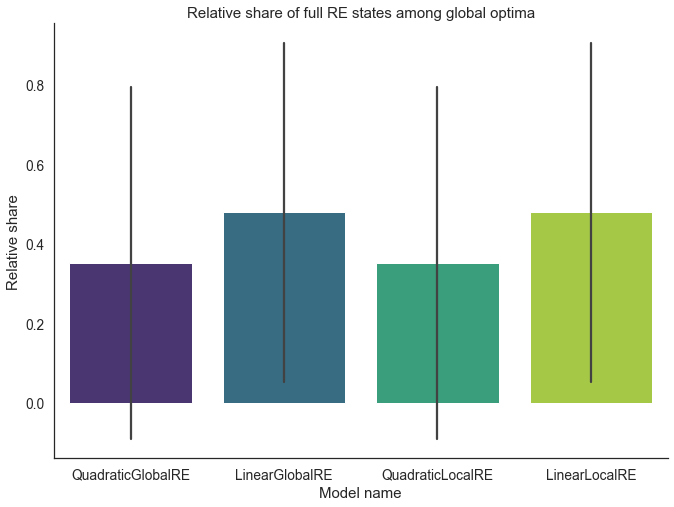

In [91]:
ax = sns.barplot(data=go_data, 
            x="model_name", 
            y="rel_go_full_re",
            hue="model_name",
            estimator=np.mean, 
            errorbar="sd",
            legend=False,
            )
ax.set(xlabel='Model name', ylabel='Relative share')
ax.set(title="Relative share of full RE states among global optima")
plt.show()

C:\Users\afrei\AppData\Local\Temp/ipykernel_11552/2966707059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fp_data, x="model_name", y="rel_fp_full_re", palette="rocket")


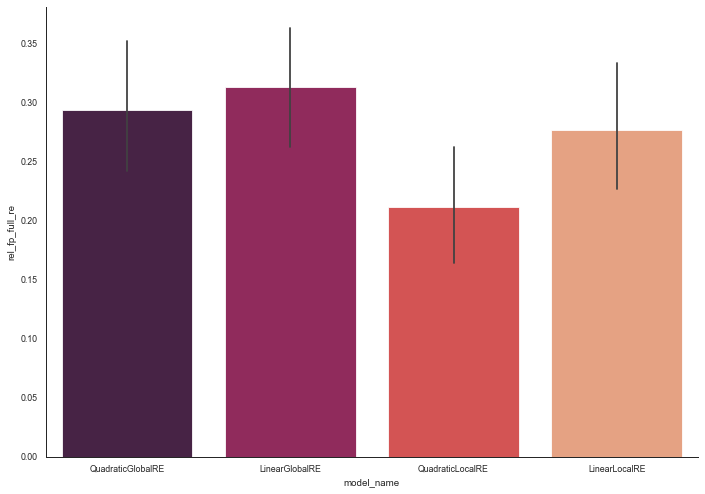

In [65]:
sns.barplot(data=fp_data, x="model_name", y="rel_fp_full_re", palette="rocket")
plt.show()

### Heatmaps

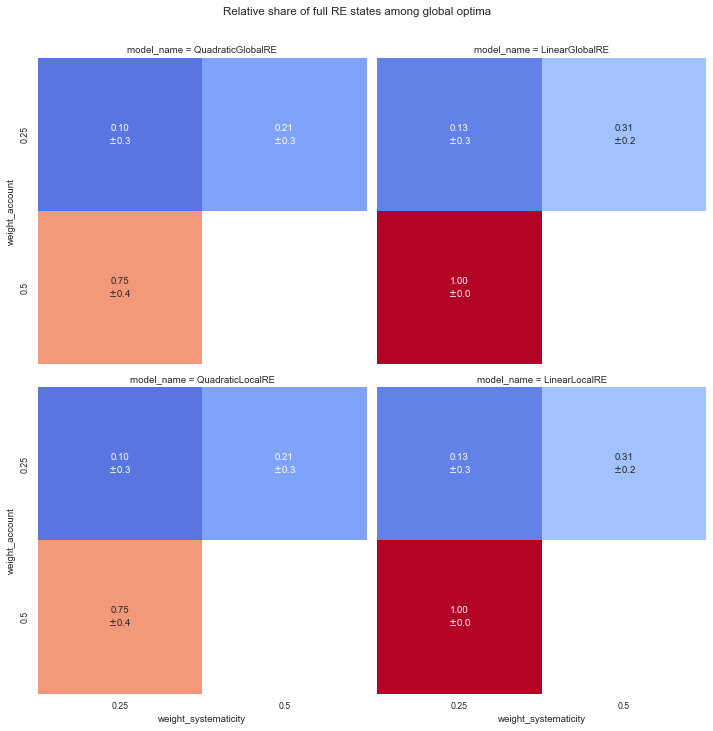

In [38]:
normalized_heat_maps_by_weights(go_data, 
                                "rel_go_full_re", 
                                "Relative share of full RE states among global optima",
                                annot_std = True,
                                annot_fmt="{:2.2f}\n")

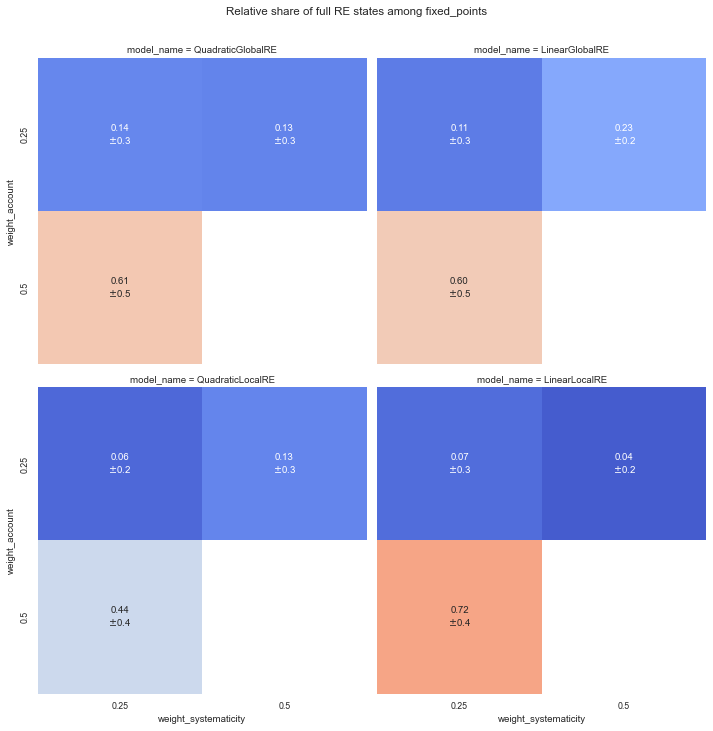

In [39]:
normalized_heat_maps_by_weights(fp_data, 
                                "rel_fp_full_re", 
                                "Relative share of full RE states among fixed_points",
                                annot_std = True,
                                annot_fmt="{:2.2f}\n")